In [1]:
import os
import json
import pathlib

import torch
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, io, models

In [2]:
""" Объявление констант """

' Объявление констант '

In [3]:
# Вычислить среднее значение и стандартное отклонение для тренировочного датасета
COMPUTE_NORMALIZE_PARAMS = True
# Путь к датасету относительно директории ноутбука
DATASET_ROOT_PATH = pathlib.Path("../../dataset/").expanduser().absolute()
CNN_FILE_NAME = "custom_resnet18.pth"
# Сколько будет занимать одине из датасетов относительно размера всего датасета
TRAIN_SIZE_FRACTION, VALID_SIZE_FRACTION, TEST_SIZE_FRACTION = (0.6, 0.2, 0.2)
BATCH_SIZE = 64
# Стандартное значение для большинства моделей
RESIZE_SIZE = (224, 224)
# Модель для тренировки
CNN = lambda: models.resnet18(pretrained=True)
CLASSES = (
    "matiz black", "matiz blue", "matiz red",
    "rio black", "rio blue", "rio red",
    "tiggo black", "tiggo blue", "tiggo red",
)

In [4]:
if COMPUTE_NORMALIZE_PARAMS:
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Загрузка тренировочного датасета и его загрузчика
    dataset = torchvision.datasets.ImageFolder(root=DATASET_ROOT_PATH, transform=transform)
    train_set, _ = torch.utils.data.random_split(
        dataset,
        (TRAIN_SIZE_FRACTION, 1 - TRAIN_SIZE_FRACTION),
        generator=torch.Generator().manual_seed(1337),
    )
    
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=1, shuffle=True, num_workers=2
    )

    # Вычисляем среднее значение и стандартное отклонение
    mean = std = imgs_count = 0
    for imgs, _ in train_loader:
        imgs = imgs.view(1, imgs.size(1), -1)
        
        mean += imgs.mean(2).sum(0)
        std += imgs.std(2).sum(0)

        imgs_count += 1
    
    mean /= imgs_count
    std /= imgs_count
else:
    # Стандартные значения для нормализации
    mean = (0.5, 0.5, 0.5)
    std = (0.5, 0.5, 0.5)

mean, std

(tensor([0.4815, 0.4523, 0.4579]), tensor([0.2643, 0.2634, 0.2638]))

In [5]:
# Если кто-то захочет использовать нестандартные значения mean и std,
# пользуясь CLI утилитой
with open("../../normalize_params.json", "w") as f:
    try:
        json.dump([mean.numpy().tolist(), std.numpy().tolist()], f)
    except AttributeError:
        json.dump([mean, std], f)

In [6]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [7]:
# Трансформация для каждой картинки
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)]
)

# Загрузка датасет, разделение на тренировочный, валидационный и тестовый
dataset = torchvision.datasets.ImageFolder(root=DATASET_ROOT_PATH, transform=transform)
train_set, valid_set, test_set = torch.utils.data.random_split(
    dataset,
    (TRAIN_SIZE_FRACTION, VALID_SIZE_FRACTION, TEST_SIZE_FRACTION),
    generator=torch.Generator().manual_seed(241423),
)

# Создание загрузчиков. Возможно, большее значение num_workers
# может ускорить процесс загрузки.
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
valid_loader = torch.utils.data.DataLoader(
    valid_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)
test_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2
)

In [8]:
""" Выведем несколько картинок из тренировочного датасета """

' Выведем несколько картинок из тренировочного датасета '

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4108575..1.5397264].


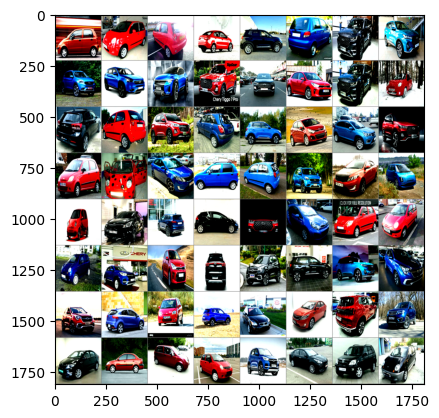

matiz red, matiz red, matiz red, rio red, tiggo black, matiz blue, tiggo black, tiggo blue, tiggo blue, tiggo blue, tiggo blue, tiggo red, tiggo black, rio red, tiggo black, matiz red, rio black, matiz red, tiggo red, rio blue, tiggo blue, rio red, tiggo blue, tiggo black, matiz red, matiz red, rio blue, matiz blue, matiz blue, tiggo blue, rio red, matiz blue, matiz red, rio black, tiggo blue, rio black, tiggo red, rio blue, matiz red, matiz red, matiz blue, tiggo blue, rio red, tiggo black, tiggo black, tiggo black, tiggo blue, tiggo blue, tiggo red, rio blue, matiz red, tiggo blue, rio black, rio red, tiggo red, tiggo blue, rio black, rio red, matiz red, matiz red, tiggo blue, rio black, tiggo black, matiz black


In [9]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print(', '.join(f'{CLASSES[labels[j]]:5s}' for j in range(BATCH_SIZE)))

In [10]:
""" Дальнейший код может отличаться от модели к модели """

' Дальнейший код может отличаться от модели к модели '

In [11]:
net = CNN()
net = net.to(device)

/home/paro/Sources/ml-introductory-project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/paro/Sources/ml-introductory-project/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
# Т.к. resnet18 ожидает некоторое другое значение классов, переназначим его.
ftrs_count = net.fc.in_features
classes_count = 9
net.fc = nn.Linear(ftrs_count, classes_count).to(device)

In [13]:
# Одна из самых частоиспользуемых функции потерь и оптимизатора
# для данной задачи
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-3, momentum=0.9, weight_decay=3e-3)

In [14]:
min_valid_loss = float("inf")
for epoch in range(32):    # Я бы рекомендовал остановиться на 32 эпохах, если вы не хотите ждать
    print(f"Epoch #{epoch + 1}")
    net.train()
    train_loss = valid_loss = 0

    # Обучаем 
    for data in train_loader:
        # Переносим данные на GPU, если возможно
        inputs, labels = data[0].to(device), data[1].to(device)

        # градинет с нулевым параметром
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)     
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Считаем потерю проверки (или как оно по-русски), чтобы
    # не переобучивать модель и сохранить ее в нужный момент.
    for data, labels in valid_loader:
        # Переносим данные на GPU, если возможно
        data, labels = data.to(device), labels.to(device)

        target = net(data)
        loss = criterion(target, labels)
        valid_loss += loss.item()

    # Статистика об эпохе.
    print(
        f"    Training Loss: {train_loss / len(train_loader)} "
        f"\t\t Validation Loss: {valid_loss / len(valid_loader)}"
    )

    # Если переобученность меньше, чем у предыдущей версии нейросети
    if min_valid_loss > valid_loss:
        print(f"    Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model")
        min_valid_loss = valid_loss
        torch.save(net.state_dict(), f'../../{CNN_FILE_NAME}')

print("Обучение модели окончено")

Epoch #1
    Training Loss: 1.9293041125587795 		 Validation Loss: 1.5424241870641708
    Validation Loss Decreased(inf--->12.339393) 	 Saving The Model
Epoch #2
    Training Loss: 1.1200513114099917 		 Validation Loss: 0.9927305057644844
    Validation Loss Decreased(12.339393--->7.941844) 	 Saving The Model
Epoch #3
    Training Loss: 0.6818318690942682 		 Validation Loss: 0.7049169167876244
    Validation Loss Decreased(7.941844--->5.639335) 	 Saving The Model
Epoch #4
    Training Loss: 0.4734600393668465 		 Validation Loss: 0.587164755910635
    Validation Loss Decreased(5.639335--->4.697318) 	 Saving The Model
Epoch #5
    Training Loss: 0.35412563189216284 		 Validation Loss: 0.5037998370826244
    Validation Loss Decreased(4.697318--->4.030399) 	 Saving The Model
Epoch #6
    Training Loss: 0.2829143366088038 		 Validation Loss: 0.44359535351395607
    Validation Loss Decreased(4.030399--->3.548763) 	 Saving The Model
Epoch #7
    Training Loss: 0.214828257975371 		 Validation 

In [15]:
""" Начните отсюда, если вы хотите протестировать модель """

' Начните отсюда, если вы хотите протестировать модель '

In [16]:
# Не вижу смысла перезагружать модель, если мы ее обучали
# в данной сессии
if not ("net" in globals() or "net" in locals()):
    net = CNN()
    ftrs_count = net.fc.in_features
    classes_count = 9
    net.fc = nn.Linear(ftrs_count, classes_count)
    net.load_state_dict(torch.load(
        f"../../{CNN_FILE_NAME}", weights_only=True
    ))    # Загружаем модель
    net = net.to(device)

net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:
"""" Выведем рандомные 4 картинки из тестового датасета """

'" Выведем рандомные 4 картинки из тестового датасета '

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4108575..1.5397264].


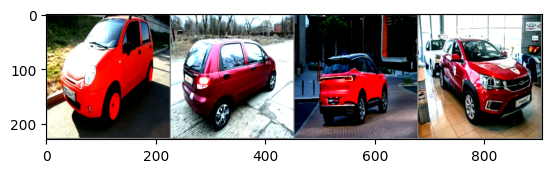

Ожидаемый результат:  matiz red, matiz red, tiggo red, tiggo red


In [18]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print(
    'Ожидаемый результат: ',
    ', '.join(f'{CLASSES[labels[j]]:5s}' for j in range(4))
)

In [19]:
# Переносим все на испрользуемое устройство
images, labels = images.to(device), labels.to(device)
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print(
    'Предсказанный результат: ',
    ', '.join(f'{CLASSES[predicted[j]]:5s}' for j in range(4))
)

Предсказанный результат:  matiz red, matiz red, tiggo red, tiggo red


In [20]:
""" Посчитаем точность модели на тестовом датасете """

' Посчитаем точность модели на тестовом датасете '

In [21]:
correct = 0
total = 0
# Поскольку мы не обучаем модель, нам не нужно считать градиент для выходных
# значений нейросети
with torch.no_grad():
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        # Выход с самым большим значением, это наш предсказанный результат
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Точность модели, основываясь на тестовом датасете: {100 * correct / total:.3f} %")

Точность модели, основываясь на тестовом датасете: 99.864 %
